## theano basic tensor functionality

## theano function()

* For more detail, refer to theano function [document](http://deeplearning.net/software/theano/library/compile/function.html)

* function() is the interface for compiling symbolic graph into callable object that can be called on a number and will do some computations. 
* The function() has many parameters, the most important of which are:
    * <b style="color:red">inputs</b>, a list of either variables or <i>In</i> instances, but not shared variables. You may think of the inputs as <b style="color:red">placeholder</b> in tensorflow.
    * <b style="color:red">outputs</b>, a list of variables or <i>Out</i> instances. They are expressions in the symbolic graph to compute.
    * <b style="color:red">updates</b>, iterable over pairs(shared_variable, new_expression); the iterable can be list, tuple or dict. 
* The function() returns a callable object of type <i>[Function](http://deeplearning.net/software/theano/library/compile/function.html#theano.compile.function_module.Function)</i>. The callable object will be called to compute/evaluate the values of expressions passed into outputs and update the implict function arguments (SharedVariable) according to the updates
* After each function evaluation (i.e., a Function is called)
    * The updates mechanism can replace the value of any SharedVariable [implicit] inputs with new values computed from the expressions in the updates list. An exception will be raised if you give two update expressions for the same SharedVariable input (that doesn’t make sense).
    * The Function returns the computed/evaluated values of expressions in the outputs list


**functions's updates mechanism**

* the updates mechanism is a very useful feature for simplying the code of updating gradient, learning rate and momentum

## theano scan()

* Mostly used in Recurrent Neural Network
* For more detail, refer to theano scan [document](http://deeplearning.net/software/theano/library/scan.html#lib-scan)
* Advantages of scan
    * Allows number of iterations to be part of symbolic graph
    * Minimizes number of GPU transfers
    * Computes gradients through sequential steps
    * Slightly faster than Python for loop with compiled theano function
    * Can lower overall memory usage by detecting amount of memory needed
* A typical scan function is defined as:


```python
outputs, updates = theano.scan(
    fn = recurrence_function,
    sequences=sequence_to_loop_over,
    outputs_info=[initial_value],
    n_steps=number_of_time_to_iterate
)

def sequence_to_loop_over(element, prior_result):
    current_result = do something on element and prior_result
    return current_result

```

* The scan() has many parameters, the most important of which are:
    * The <b style="color:red">fn</b> argument is the function that is going to apply to every element of the sequence that you pass in.
    * The <b style="color:red">sequence</b> argument indicates the sequence (i.e., tensor(s)) to be looped over. Every individual element in teh sequence will have the same function indicated by <b style="color:red">fn</b> applied on it. 

    > Note that scan iterates over the leading dimension of tensors 

    * The <b style="color:red">outputs_info</b> argument indicates the initial output value and it can be more than one initial output value. 
        * The initial output value(s) will be passed to the prior_result argument of the sequence_to_loop_over function for the first iteratoin. 
        * The result (in this case, current_result) of current iteration will be passed to the prior_result argument for computation in the next iteration. If the outputs_info is a list, the current_result should also be a list with the same number of elements.
        * The outputs_info, must be of a shape similar to that of the output variable generated at each iteration and moreover, it must not involve an implicit downcast of the latter.
    * The <b style="color:red">n_steps</b> argument indicates the number of steps to iterate over the passed-in sequence. Typically, it is the length of the sequence.
    * The <b style="color:red">non_sequences</b> argument indicates the variables whose values will not be changing through out the whole iteration.
    
    
* The scan() returns two things in a tuple:
    * result/output

    > The result is not a matrix, but a <b style="color:red">3D</b> tensor containing the value of result/output for each step. For example, if the sequence is [1,2,3] and the function is square, the result would be [1,4,9]

    > The result is not the value of the result but <b style="color:red">Symbolic description</b> of the result. It can be used to create other expressions or passed into the outputs argument of a function. Only when the symbolic graph containing the result is evaluated, will the result be evaluated to value(s)

    * a dictionary of updates

> The theano will do some optimization on the scan. For example, if the theano, at compile time,  detects that you are using just the last value of the result, theano will ensure that scan does not store all the intermediate values that are used. 

In [2]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt

### Simple Square Example

In [8]:
x = T.vector('x')

def square(x):
    return x*x

outputs, updates = theano.scan(
    fn=square, 
    sequences=x,
    n_steps=x.shape[0])

square_op = theano.function(
    inputs=[x], 
    outputs=[outputs])

o_val = square_op(np.array([1,2,3,4,5]))
print(o_val)

[array([  1.,   4.,   9.,  16.,  25.])]


### Low Pass Filter 

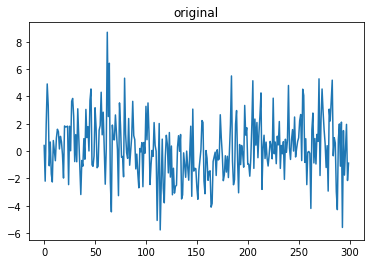

In [28]:
X = 2*np.random.randn(300) + np.sin(np.linspace(0, 3*np.pi, 300))
X = X.astype(np.float32)
plt.plot(X)
plt.title('original')
plt.show()

(300,)


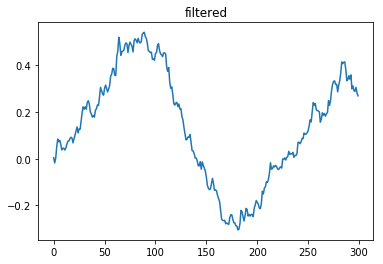

In [29]:
decay = T.scalar('decay')
sequence = T.fvector('sequence')

def recurrence(x, prior, decay):
    return (1 - decay) * x + decay * prior

outputs, _ = theano.scan(
    fn=recurrence,
    sequences=sequence,
#     n_steps=sequence.shape[0],
    outputs_info=np.float64(0),
    non_sequences=decay,
)

lpf = theano.function(
    inputs=[sequence, decay],
    outputs=outputs,
)

o_val = lpf(X, 0.99)
print(o_val.shape)
plt.plot(o_val)
plt.title('filtered')
plt.show()

In [3]:
k = T.iscalar("k")
A = T.vector("A")

# Symbolic description of the result
result, updates = theano.scan(fn=lambda prior_result, A: prior_result * A,
                              outputs_info=T.ones_like(A),
                              non_sequences=A,
                              n_steps=k)

# We only care about A**k, but scan has provided us with A**1 through A**k.
# Discard the values that we don't care about. Scan is smart enough to
# notice this and not waste memory saving them.
final_result = result[-1]

# compiled function that returns A**k
power = theano.function(inputs=[A,k], outputs=[final_result, result], updates=updates)

yyy = range(10)
print(type(yyy))
output, y = power(range(10),2)

# yy = y[:, 0, :]
print("y:", y.shape)
print("y type:", type(y))
print("y:", y)
print("output:", output)
# print(power(range(10),2))
# print(power(range(10),4))

<class 'range'>
y: (2, 10)
y type: <class 'numpy.ndarray'>
y: [[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.]
 [  0.   1.   4.   9.  16.  25.  36.  49.  64.  81.]]
output: [  0.   1.   4.   9.  16.  25.  36.  49.  64.  81.]
